In [1]:
### Notebook for P3D stuff!

import jax
jax.config.update('jax_platform_name', 'gpu')
from jax.lib import xla_bridge
print("jax version",jax.__version__)
print(xla_bridge.get_backend().platform)

import numpy as np
import jax.numpy as jnp

%pylab inline

jax version 0.4.26
gpu
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
#from jaxpm.kernels import *
#uses jaxpm for some kernels... maybe?

In [3]:
#First things... set the redshift

z= 2.0

#set box geometry, probably should wrap this into the fiducial model file (hdf5?) to lead to less fiddling bugs

bs =  320#box size in Mpc/h
nc =  128#number of pixels per side

mesh_shape = [nc,nc,nc]
box_size = [bs,bs,bs]

ptcl_grid_shape = (nc,) * 3
ptcl_spacing = bs/nc



In [4]:
#some fourier space routines
from helper_functions import *

kvec = rfftnfreq_2d(ptcl_grid_shape, ptcl_spacing)
k = jnp.sqrt(sum(k**2 for k in kvec))
#this vector is needed for lots of fourier space transformation operations later on...
print(k.shape)

/tmp/ipykernel_154991/2721841557.py:5: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  k = jnp.sqrt(sum(k**2 for k in kvec))
2025-03-24 21:51:10.400294: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.8.93). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(128, 128, 65)


In [5]:
#in this setup, LOS (z) is along the 0 axis, be careful when loading in data!

kz = jnp.ones(k.shape)*kvec[0]**2

kx = jnp.ones(k.shape)*(kvec[1]**2+kvec[2]**2)
#tiny deltas are added to avoid div by zero errors
kk = (kx+kz)+10**(-8)
kmu = jnp.sqrt((kz/(k**2+0.00001)))


In [6]:
np.max(k)


Array(2.1765592, dtype=float32)

In [7]:
#m_array[:,0][:50].max()
from jax import jit, checkpoint, custom_vjp
from jax.scipy.ndimage import map_coordinates

#loading in fiducial model
m_array = np.load("pkell_red.npy")
m_array = jnp.array(m_array[np.where(m_array[:,1]<6)])
kmax = m_array[-1,0]
print(m_array.shape,kmax)


(93, 3) 3.0507545


In [8]:
import jaxinterp2d

k_in = (k.flatten()/kmax*31-0.6)

l0 = np.where(m_array[:,1]==0)[0]
k_l0 = m_array[l0,0]
Pk_l0 = m_array[l0,2]
func1 = map_coordinates(Pk_l0,np.array([k_in]),mode="nearest",order=1)
func1 = func1.reshape(128,128,65)

l2 = np.where(m_array[:,1]==2)[0]
k_l2 = m_array[l2,0]
Pk_l2 = m_array[l2,2]
func2 = map_coordinates(Pk_l2,np.array([k_in]),mode="nearest",order=1)
func2 = func2.reshape(128,128,65)

l4 = np.where(m_array[:,1]==4)[0]
k_l4 = m_array[l4,0]
Pk_l4 = m_array[l4,2]
func4 = map_coordinates(Pk_l4,np.array([k_in]),mode="nearest",order=1)
func4 = func4.reshape(128,128,65)



In [9]:
k_l0

Array([0.0727261 , 0.1606284 , 0.25728098, 0.3545217 , 0.45364597,
       0.55350095, 0.65304476, 0.75254625, 0.85181415, 0.95151144,
       1.0518534 , 1.151781  , 1.2514049 , 1.3515313 , 1.4514774 ,
       1.5512495 , 1.6511518 , 1.7510082 , 1.8509479 , 1.9507843 ,
       2.050715  , 2.1508641 , 2.2509792 , 2.3509562 , 2.4508038 ,
       2.5507815 , 2.6507885 , 2.7507381 , 2.8507483 , 2.950734  ,
       3.0507545 ], dtype=float32)

In [10]:
k_ind_optim_max = 22
ell_bins=3
k_bins=31
tff = m_array[:,2].reshape(ell_bins,k_bins)
theta_fid = m_array[:,2].reshape(ell_bins,k_bins)[:,:k_ind_optim_max]

from scipy.special import legendre

def power_b(theta,tff=tff):    
    tff = tff.at[:,:k_ind_optim_max].set(theta.reshape(ell_bins,k_ind_optim_max))
    func1 = map_coordinates(tff[0], np.array([k_in]), mode="nearest", order=1)
    func1 = func1.reshape(128,128,65)
    func2 = map_coordinates(tff[1], np.array([k_in]), mode="nearest", order=1)
    func2 = func2.reshape(128,128,65)
    func4 = map_coordinates(tff[2], np.array([k_in]), mode="nearest", order=1)
    func4 = func4.reshape(128,128,65)
    func = jax.nn.relu(func1*legendre(0)(kmu)+func2*legendre(2)(kmu)+func4*legendre(4)(kmu))
    return func/15


In [11]:
#muse componenet...
from functools import partial
import jax
import jax.numpy as jnp
from muse_inference.jax import JaxMuseProblem

In [12]:

#file name
prefix = "V1_DENSE_"
loc = "./configs/"

naa = np.load(loc+prefix+"naa.npy")
kernel = np.load(loc+prefix+"kernel.npy")
skewers_skn = np.load(loc+prefix+"skewers_skn.npy")
skewers_dla = np.load(loc+prefix+"skewers_dla.npy")
skewers_fin = np.load(loc+prefix+"skewers_fin.npy")



@jit
def cic_readout_jit_jnc(mesh,naa,kernel,bs=False):
    #"highly optimized" CIC, need to preprocess lots of things... don't diff output coords
    meshvals = mesh.flatten()[naa].reshape(-1,8).T#mesh[tuple(neighboor_coords[0,:,:].T.tolist())]
    weightedvals = meshvals.T* kernel[0]
    values = np.sum(weightedvals, axis=-1)
    
    return values



In [13]:
tf_cut_flat = theta_fid.flatten()

noise_level = 1.0

def gen_map_lya(theta,z):
    modes = z[:nc**3].reshape((nc,nc,nc))    
    Plin = power_b(theta)
    conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
    lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

    lya_values = cic_readout_jit_jnc(lin_modes_real,naa,kernel)
    return lya_values
                 
class Jax3DMuseProblem_flat(JaxMuseProblem):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    #@jax.jit
    def sample_x_z(self, key, θ):
        keys = jax.random.split(key, 2)
        z = jax.random.normal(keys[0], (nc*nc*nc,))
        
        x = gen_map_lya(θ,z) + (0.05*skewers_skn)*jax.random.normal(keys[1], (kernel.shape[1],)) #1*jax.random.normal(keys[1], (32**3,)).reshape((32,32,32))
   #     print(z.shape,x.shape)
        return (x, z)

  #  @jax.jit
    def logLike(self, x, z, θ):
        return -(jnp.sum((x - gen_map_lya(θ,z))**2/((0.05*skewers_skn)**2))+ jnp.sum(z**2.0))

  #  @jax.jit
    def logPrior(self, θ):
        return -jnp.sum(((θ-jnp.array(tf_cut_flat)*1.1)**2 / (2*(tf_cut_flat*0.4)**2)))
    


In [14]:
prob = Jax3DMuseProblem_flat(implicit_diff=True,jit=False)
key = jax.random.PRNGKey(100)
(x, z) = prob.sample_x_z(key, tf_cut_flat)
prob.set_x(x)

In [15]:
modes = z[:nc**3].reshape((nc,nc,nc))    
Plin = power_b(tf_cut_flat)
conv_field = jnp.fft.rfftn(modes).conj()*Plin**(1/2)
lin_modes_real = jnp.fft.irfftn(conv_field).T[:,:,:]

np.save("example_gen_field",lin_modes_real)

In [16]:
rng = jax.random.PRNGKey(1)

In [17]:
x_data = x

In [18]:
from numpy.random import SeedSequence, default_rng
from copy import copy

start_point = jnp.array(tf_cut_flat)*1.2#+np.random.randn(len(tf_cut_flat))*jnp.array(tf_cut_flat)*0.01)

def _split_rng(rng, N):
    keyz = []
    for i in range(N):
        rng, subkey = jax.random.split(rng)
        keyz.append(rng)
    return keyz
    
θ = start_point

maxsteps = 100
nsims= 10
rng = jax.random.PRNGKey(1)

xz_sims = [prob.sample_x_z(_rng, θ) for _rng in _split_rng(rng, nsims)]
xs = [x_data] + [x for (x,_) in xz_sims]
ẑs = [z*0]     + [z*0 for (x, z) in xz_sims]

In [19]:
print(x_data)

[ 0.08874138  0.13179183  0.12778719 ... -0.01290748  0.00572114
  0.01427989]


In [20]:
from jax import grad, hessian, jacfwd, jvp, value_and_grad, vmap

def gradθ_hessθ_logPrior(θ, transformed_θ=None):
        g = grad(prob.logPrior)(θ)
        H = hessian(lambda θ_vec: prob.logPrior(unravel_θ(θ_vec)))(ravel_θ(θ))
        return (g, H)

step: 1 0.5
[[-4.6625125e-08  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.0870876e-08  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -5.3230139e-11 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.7199083e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -8.3864741e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.9234882e-06]]
[0.20000279 0.2000332  0.20000072 0.19999997 0.20000075 0.20000064
 0.20000146 0.20000158 0.19999933 0.19999851 0.19999851 0.19999856
 0.19999859 0.19999816 0.19999737 0.19999613 0.19999316 0.19998208
 0.19993441 0.19977349 0.19909222 0.19219002 0.19999458 0.19999646
 0.2000096  0.2000037  0.20000161 0.20000419 0.19998284 0.19945641
 0.20040232 0.20004913 0.20002046 0.19999582 0.199977

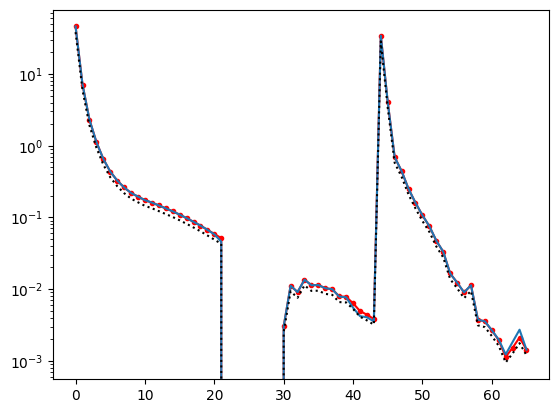

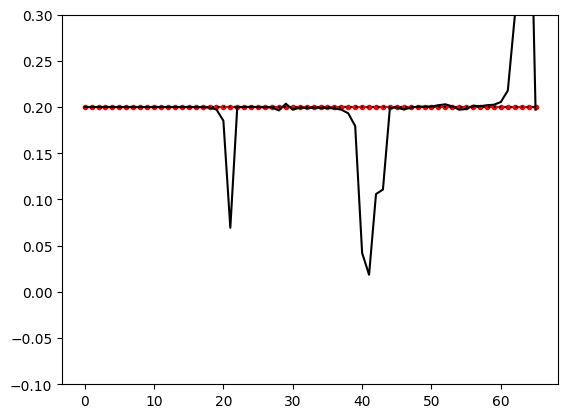

step: 4 0.475
[[-1.8210694e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.0929155e-08  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.3695620e-07 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.5062920e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -9.9187866e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -4.6104396e-05]]
[0.19993927 0.2000441  0.1999103  0.19999579 0.19999823 0.19999793
 0.19999675 0.19996601 0.19997762 0.19998473 0.19998802 0.19998966
 0.19999005 0.19998744 0.19998139 0.1999678  0.19993262 0.19980939
 0.1992275  0.19623415 0.1793467  0.01074285 0.1998731  0.19990526
 0.2004858  0.19999754 0.19998318 0.20034744 0.1950568  0.19903718
 0.20155714 0.2016805  0.20126183 0.19985235 0.1987

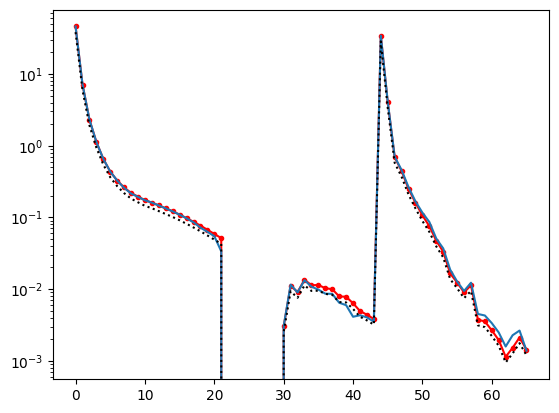

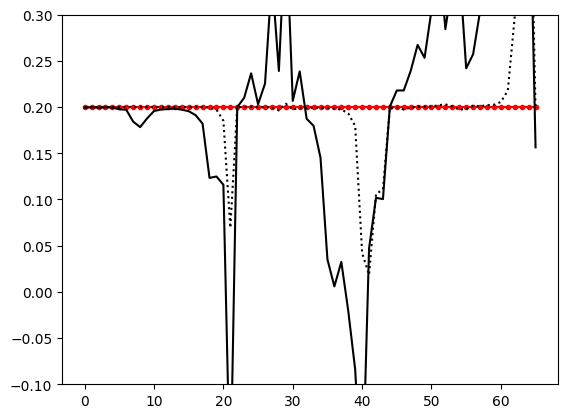

step: 7 0.45125
[[-1.65426754e-03  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.21547190e-04  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -1.06601165e-05 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -2.65166568e-06
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -7.50372783e-06  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -1.56607508e-04]]
[ 0.19967456  0.19666128  0.19696973  0.19638924  0.188465    0.1881395
  0.19171306  0.18007669  0.17348033  0.18303414  0.19162843  0.19364068
  0.1931601   0.19442329  0.18645056  0.18137985  0.15907732  0.1565538
  0.10005108  0.09093714  0.08074692 -0.30360708  0.1958428   0.21390165
  0.31474727  0.23123491  0.28345874  0.45616445  0.260132

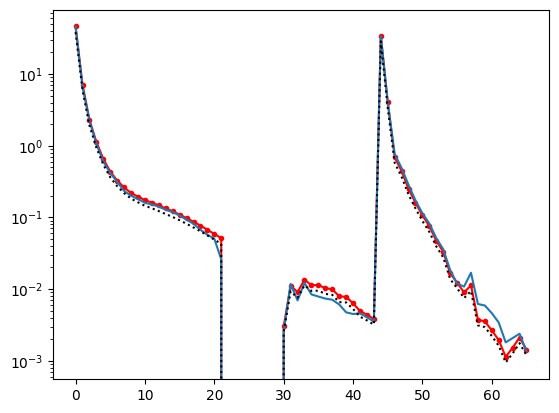

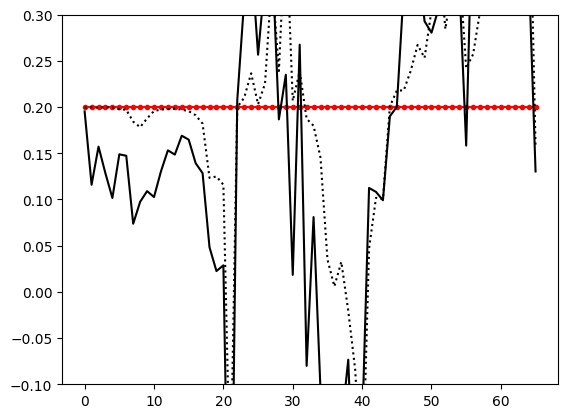

step: 10 0.42868749999999994
[[-4.2503297e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0756890e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.3433403e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.8676487e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.2690637e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.2810118e-04]]
[ 0.2256746   0.16911289  0.13518585  0.06721787  0.02041382  0.13150977
  0.13321511  0.05514817  0.08542179  0.10857929  0.10552458  0.13257773
  0.14830936  0.14268593  0.16118063  0.15672858  0.13098085  0.11796491
  0.04137892  0.01910511  0.02323862 -0.380646    0.26719138  0.20627996
  0.5125189   0.37397528  0.48262897  0.22241567  0.05951359  0.18472785
 -0.09

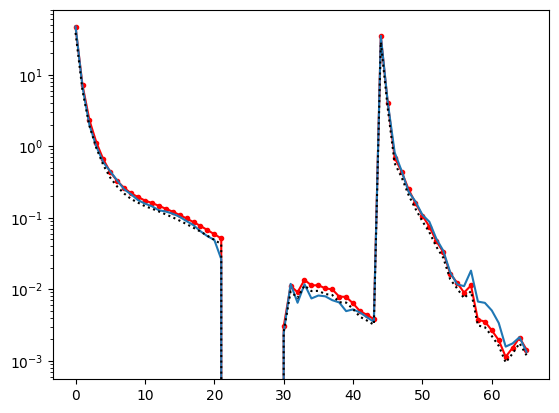

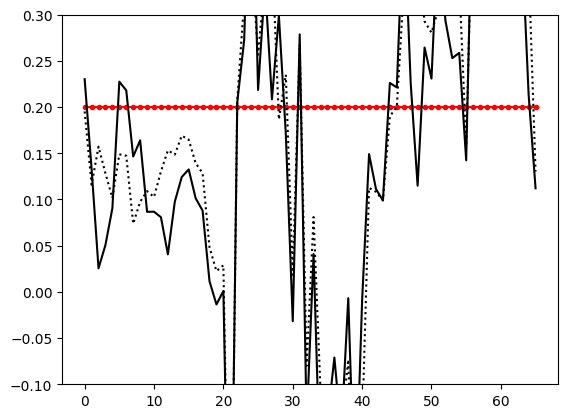

step: 13 0.40725312499999994
[[-2.6542402e-03  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.8255540e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.9866398e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -7.5515709e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.5005999e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.3204757e-04]]
[ 0.23026304  0.15079309  0.02893656  0.04821065  0.04363418  0.20171787
  0.19513816  0.08600039  0.06291898  0.0699624   0.08170018  0.0788583
  0.04034359  0.09624901  0.11439361  0.1168033   0.07796539  0.07441735
  0.006829   -0.01527046 -0.00250172 -0.37230578  0.2049907   0.21312466
  0.41603324  0.19545965  0.3430196   0.33140388  0.2903394   0.14361869
 -0.006

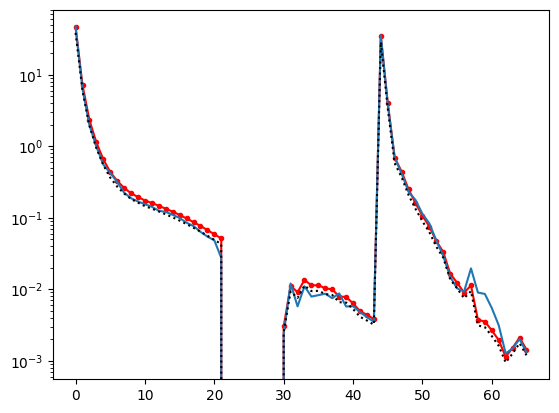

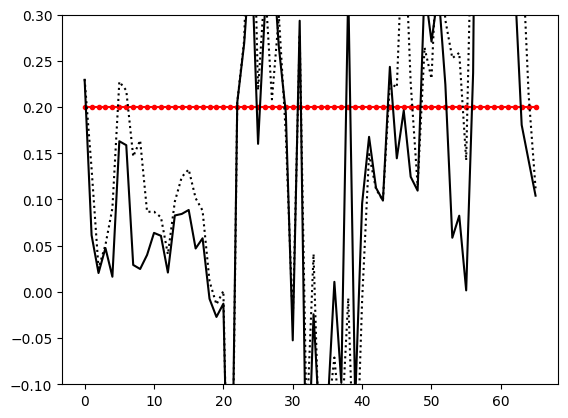

step: 16 0.38689046874999994
[[-2.4438217e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.5579031e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.0860149e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.2991967e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.4415903e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.5508909e-04]]
[ 0.2311634   0.06587628  0.02392383  0.04575721  0.01203326  0.1531
  0.14845428  0.01781134  0.02174213  0.03509094  0.05526615  0.05240509
  0.01384169  0.07124585  0.07967699  0.08338522  0.04024838  0.04894267
 -0.01178026 -0.02996489 -0.01605764 -0.35229665  0.20607507  0.27563444
  0.29300058  0.13949856  0.26991823  0.32934746  0.22465394  0.14989144
 -0.051936

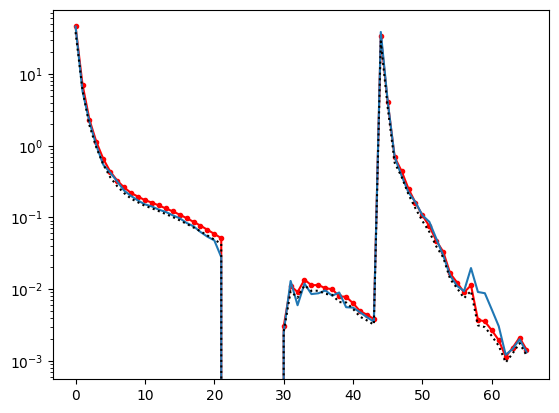

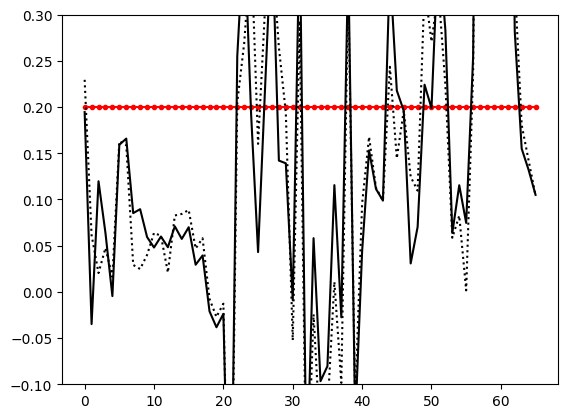

step: 19 0.3675459453124999
[[-3.0555425e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.3365531e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.9543278e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0038113e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.8367029e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.6872125e-04]]
[ 0.19645767 -0.02677035  0.11094822  0.06587104 -0.00399839  0.1443649
  0.15019476  0.05976271  0.04361947  0.04126674  0.03952039  0.04807677
  0.02971259  0.0647691   0.05168507  0.06441823  0.02949168  0.04012964
 -0.01521245 -0.02741039 -0.01860693 -0.3309216   0.26319253  0.26544443
  0.14768434  0.03367993  0.20343398  0.36418107  0.13548301  0.17562056
 -0.0485

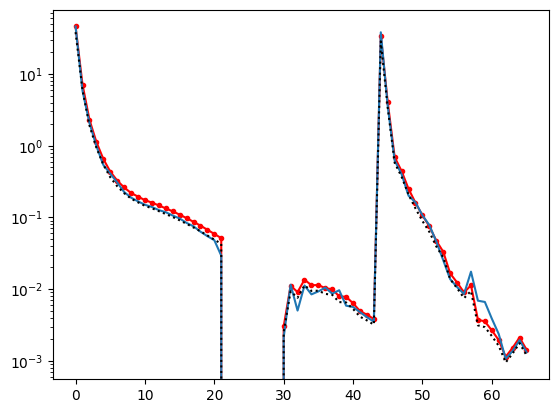

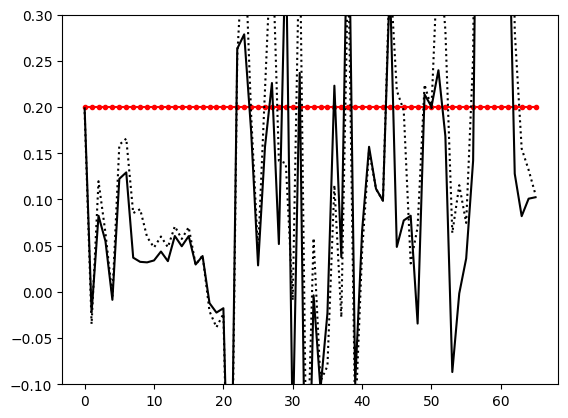

step: 22 0.34916864804687486
[[-7.1557619e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -8.5346829e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6415417e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0173774e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.8886161e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.7794930e-04]]
[ 0.21083716  0.05479201 -0.01208465  0.00518973 -0.05314615  0.13746741
  0.16622907  0.11904902  0.02258265  0.01094973  0.02944255  0.02518393
 -0.05694328  0.04679108  0.02012696  0.03948583 -0.00261958  0.02421569
 -0.02834354 -0.04290102 -0.03101557 -0.33437115  0.30408165  0.16709365
  0.27643728  0.00903991  0.25816134  0.33306104  0.1435923   0.26379427
 -0.08

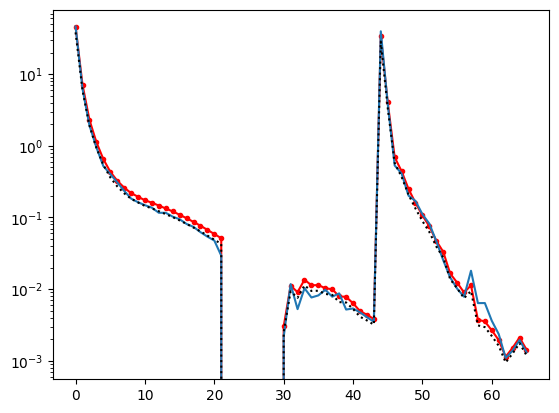

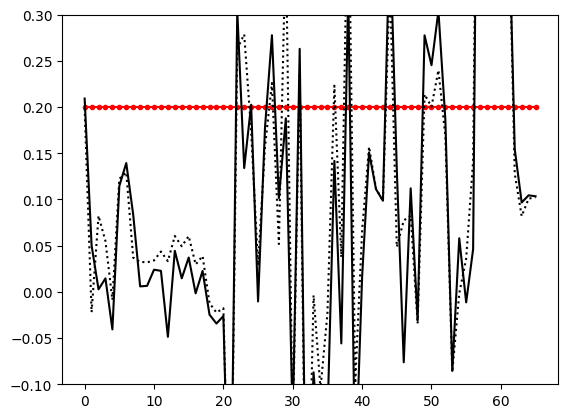

step: 25 0.3317102156445311
[[-4.7950357e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.3674501e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6830085e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -8.9278992e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.8759667e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.8265443e-04]]
[ 2.07219079e-01  4.03093882e-02  7.48650078e-03  1.75078809e-02
 -3.75790708e-02  1.04726523e-01  1.24305211e-01  6.62376508e-02
  6.84351427e-03  5.87004982e-03  2.19956040e-02  2.14871913e-02
 -4.34004776e-02  4.30783369e-02  1.06235649e-02  3.48160192e-02
 -1.42433404e-04  2.29674429e-02 -2.27674544e-02 -3.13483030e-02
 -2.42629629e-02 -3.08247268e-01  3.05481136e-0

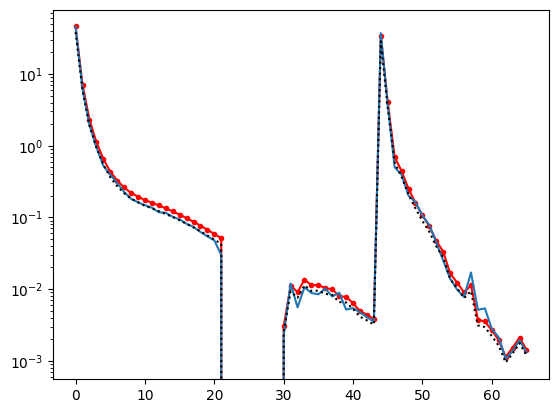

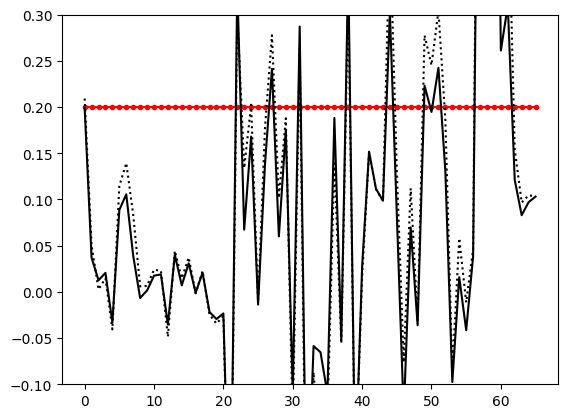

step: 28 0.31512470486230454
[[-1.6321076e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.1630150e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5685260e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.4065354e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.9330628e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.8787877e-04]]
[ 1.98380575e-01  3.04276310e-02  1.22934571e-02  2.30422579e-02
 -3.02148852e-02  8.28303471e-02  9.91658792e-02  3.10049355e-02
 -3.79650039e-03  1.68658048e-03  1.60988905e-02  1.78866759e-02
 -3.22168693e-02  3.88986915e-02  1.05606783e-02  3.02796550e-02
 -5.80450462e-04  2.03404129e-02 -2.10434962e-02 -2.82804519e-02
 -2.28566788e-02 -2.97165930e-01  3.30347478e-

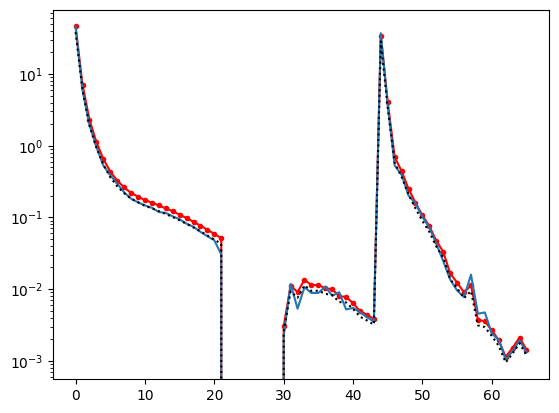

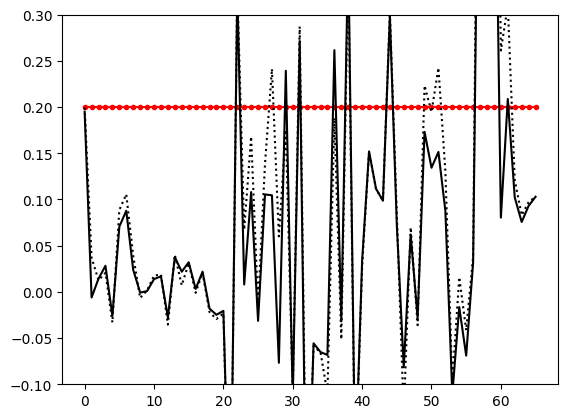

step: 31 0.2993684696191893
[[-1.0893919e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -6.5340842e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.0317594e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -9.5998957e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -1.9620067e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.9492136e-04]]
[ 1.95770115e-01  1.06200408e-02  2.08100509e-02  2.12086234e-02
 -2.73833834e-02  6.28868341e-02  8.08478147e-02  1.91819500e-02
 -3.41914454e-03  4.40524745e-04  1.30696017e-02  1.48392124e-02
 -4.19891700e-02  3.17218900e-02 -5.46237044e-02  1.22172888e-02
 -1.69137605e-02  1.00794258e-02 -2.83268299e-02 -3.71598303e-02
 -3.01285423e-02 -3.04637909e-01  3.34150314e-0

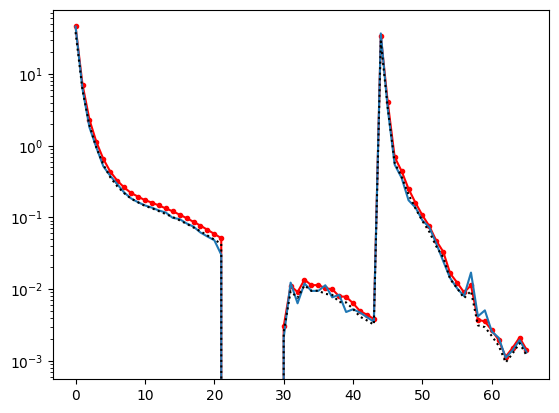

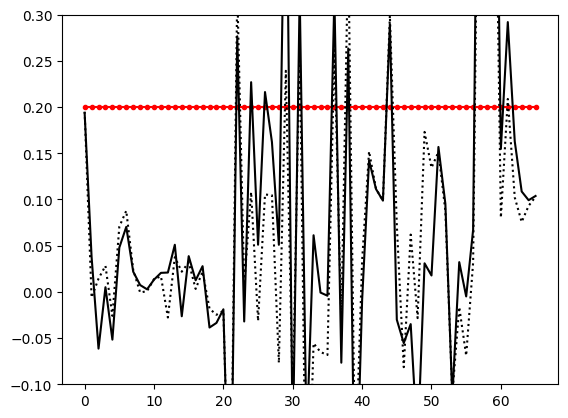

step: 34 0.2844000461382298
[[-4.6733841e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -2.0932052e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.6390202e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0431862e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.0153173e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0155901e-04]]
[ 1.93252087e-01  3.57198231e-02 -5.17576188e-02  9.64144338e-03
 -4.50048819e-02  4.48489636e-02  6.51089698e-02  1.42518682e-02
 -6.37308462e-04  6.68825887e-05  1.08934259e-02  1.62289627e-02
  1.22688962e-02  4.68600467e-02 -2.20512468e-02  3.30813602e-02
  5.70503017e-03  2.37240028e-02 -3.57600562e-02 -3.13162990e-02
 -2.00062059e-02 -2.94431984e-01  2.76804596e-0

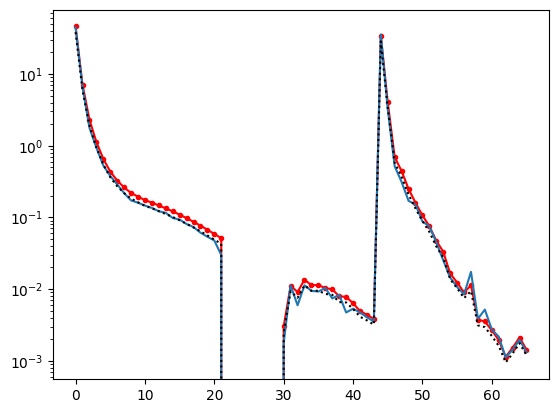

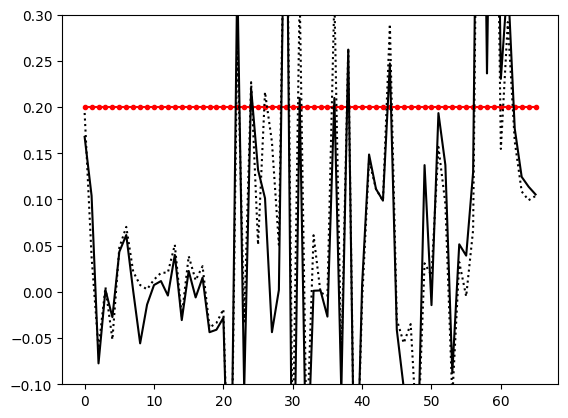

step: 37 0.2701800438313183
[[-2.5886972e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0832602e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.9777064e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0080753e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.0792058e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0697570e-04]]
[ 0.175937    0.11350711 -0.07641424  0.0093781  -0.02258383  0.04069639
  0.05893484  0.0160652  -0.04852999 -0.00741928  0.00915255  0.01630705
  0.0081077   0.04516217 -0.0119223   0.03746799  0.00896066  0.02776466
 -0.02168882 -0.02090446 -0.01565081 -0.28103268  0.3252939  -0.1396996
  0.2815207   0.12329649  0.08605211  0.01384821 -0.01321035  0.45246544
 -0.2522

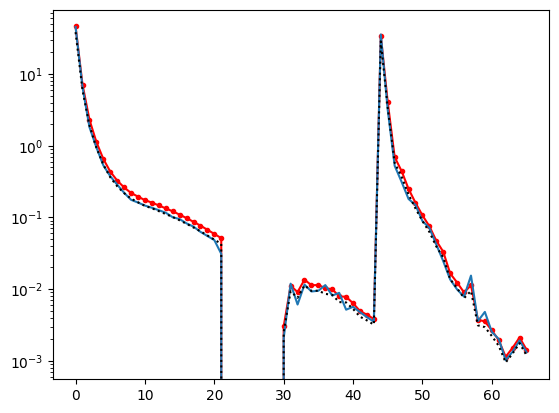

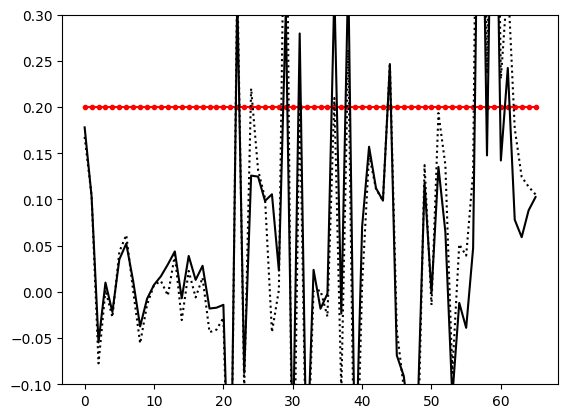

step: 40 0.25667104163975235
[[-4.9052984e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.4615697e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.4135091e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0432145e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.1029358e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.1727069e-04]]
[ 0.17519626  0.12699223 -0.03025075  0.01722421 -0.01358896  0.03304469
  0.04939862  0.00807269 -0.03964718 -0.00716425  0.00638209  0.00776654
  0.00170307  0.03210215 -0.01817992  0.02448525 -0.00359491  0.01724808
 -0.03348485 -0.03374863 -0.02579537 -0.29438263  0.32103497 -0.09917833
  0.0536101   0.07734755  0.03341746  0.1246526   0.08863468  0.38862923
 -0.22

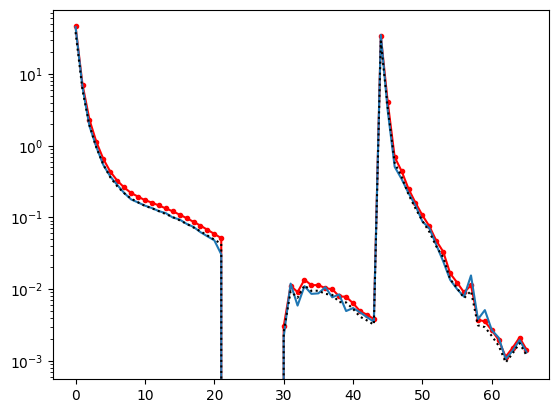

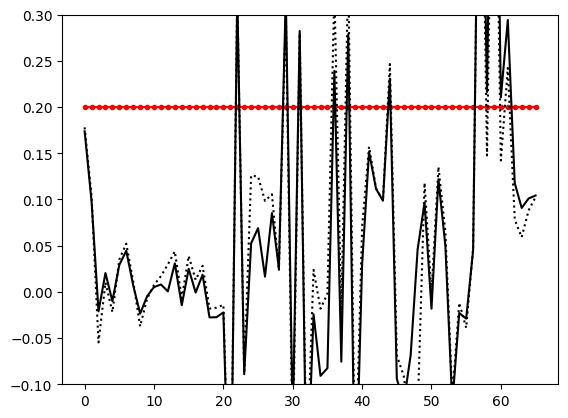

step: 43 0.24383748955776471
[[-8.2644396e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.8330116e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.6390617e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0176638e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.0918129e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.1274741e-04]]
[ 0.17229505  0.08057046 -0.02116975  0.02265677 -0.00998169  0.02749241
  0.04241455  0.00558258 -0.0250433  -0.00510898  0.00480451  0.00855063
  0.00397948  0.03125077 -0.009664    0.02832224  0.00412196  0.02079519
 -0.02371139 -0.02356922 -0.01962449 -0.28048566  0.32196188 -0.06863946
  0.06845217  0.05790803  0.0356032   0.09387418  0.00789068  0.30291513
 -0.09

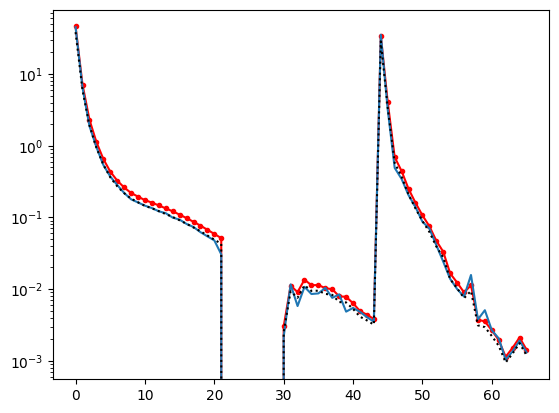

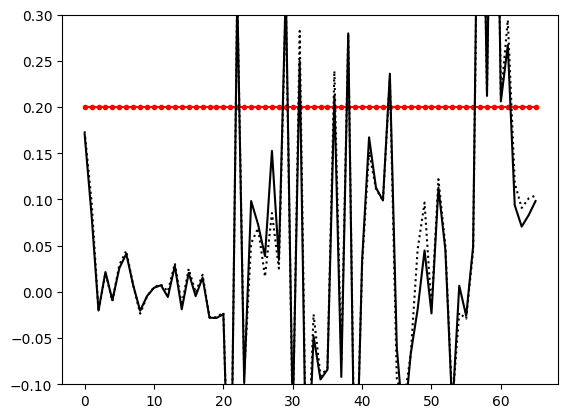

step: 46 0.23164561507987647
[[-9.0789279e-17  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.8770572e-15  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.4508144e-15 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -5.1847064e-09
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.3229850e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.2977521e-08]]
[ 0.17059869  0.08290967 -0.02018226  0.02147762 -0.00900308  0.02565094
  0.04110495  0.00719476 -0.02044065 -0.0044758   0.00442506  0.00717378
 -0.00556721  0.02821183 -0.01887012  0.02060955 -0.00459561  0.01538287
 -0.02788891 -0.02829636 -0.02425893 -0.2865509   0.32429343 -0.09867656
  0.09828442  0.07302506  0.03871625  0.15260348  0.03463051  0.32827336
 -0.13

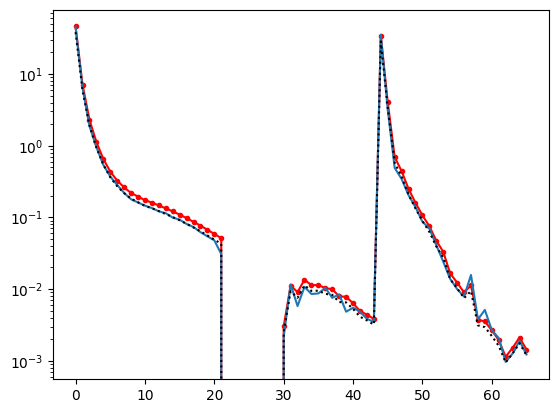

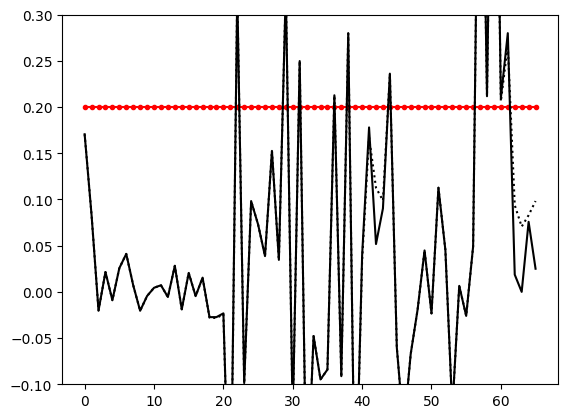

step: 49 0.22006333432588263
[[-2.2377450e-15  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.1433094e-14  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -7.8885723e-14 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.8126910e-07
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -7.7864904e-08  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.3134432e-07]]
[ 0.17059869  0.08290967 -0.02018232  0.02147762 -0.00900308  0.02565094
  0.04110451  0.00719415 -0.02044082 -0.00447608  0.00442218  0.00717189
 -0.00556769  0.02820822 -0.01889177  0.02052121 -0.00461393  0.01541834
 -0.02708375 -0.02107307 -0.02258183 -0.27854174  0.32429343 -0.09867656
  0.09828521  0.07302709  0.03871625  0.15259916  0.03462588  0.32804367
 -0.13

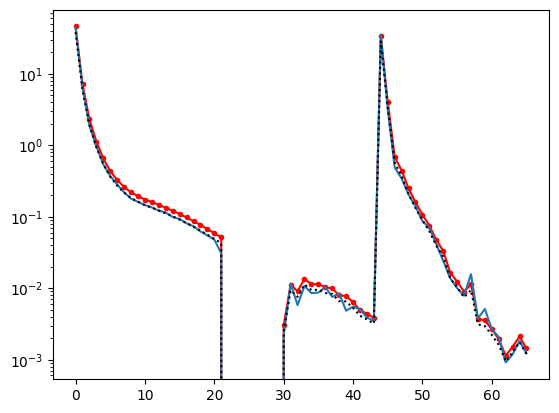

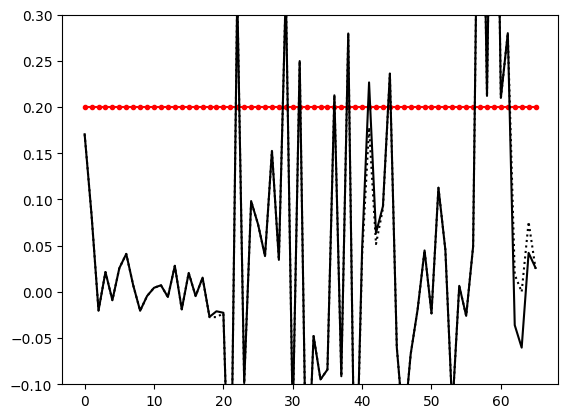

step: 52 0.20906016760958848
[[-3.1266483e-03  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.6682064e-04  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.3355826e-05 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -6.4368160e-06
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.4715405e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.3145809e-04]]
[ 0.17084181  0.08055315 -0.02034741  0.02153339 -0.00860386  0.02367215
  0.03777067  0.0069096  -0.0197346  -0.00403537  0.00290733  0.00642674
 -0.00635007  0.02713721 -0.02019986  0.01782029 -0.00846989  0.01327712
 -0.02822787 -0.0231431  -0.02741713 -0.27724236  0.32379386 -0.09421545
  0.1106886   0.08319166  0.06748797  0.18916279  0.02545465  0.31380764
 -0.14

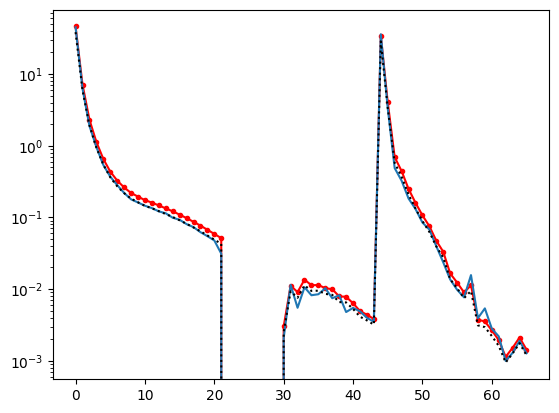

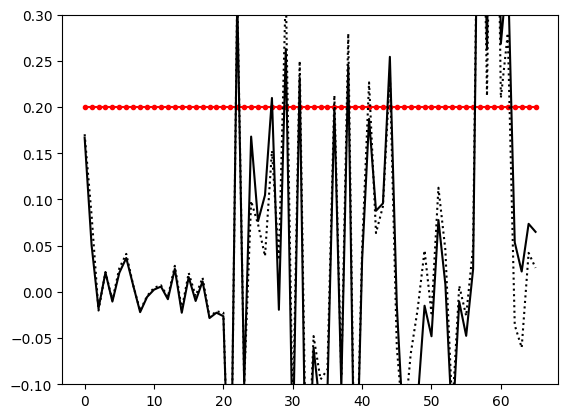

step: 55 0.19860715922910904
[[-5.6235384e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.5523538e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.8713071e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1215394e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.4872424e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0850847e-04]]
[ 1.60587639e-01 -1.60221767e-03 -3.47461998e-02  4.76445779e-02
  1.71957947e-02  2.45976150e-02  3.39050665e-02  5.51648578e-03
  1.90203022e-02  8.26358330e-03  5.00031002e-03  8.16776231e-03
 -4.56549367e-03  2.61753425e-02 -1.17322458e-02  1.82394423e-02
 -5.89701766e-03  1.35453939e-02 -2.41022743e-02 -1.46211041e-02
 -1.51706021e-02 -2.60039151e-01  3.17671478e-

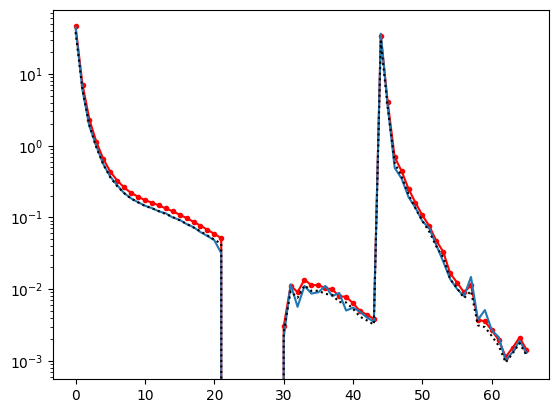

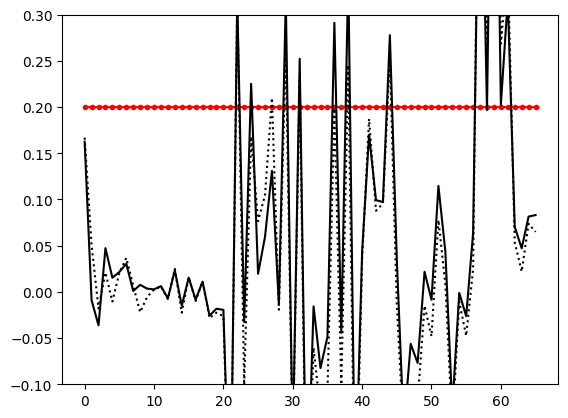

step: 58 0.18867680126765357
[[-5.80571517e-02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -1.19829820e-02  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.07964549e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.08389995e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -3.26583977e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.10802347e-04]]
[ 1.62473470e-01 -8.04274157e-03 -3.13511081e-02  4.63406183e-02
  1.40168536e-02  2.06224527e-02  2.93455422e-02  2.86121096e-04
  6.92009553e-03  3.05620371e-03  2.24939384e-03  6.03141217e-03
 -6.65286044e-03  2.25454960e-02 -1.53327370e-02  1.39933750e-02
 -9.10703652e-03  1.04364669e-02 -2.55552046e-02 -1.84451062e-02
 -1.992385

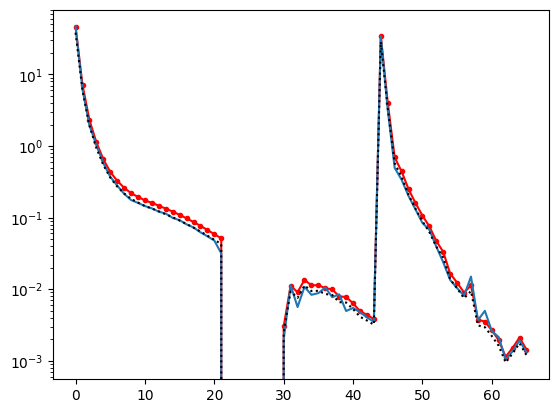

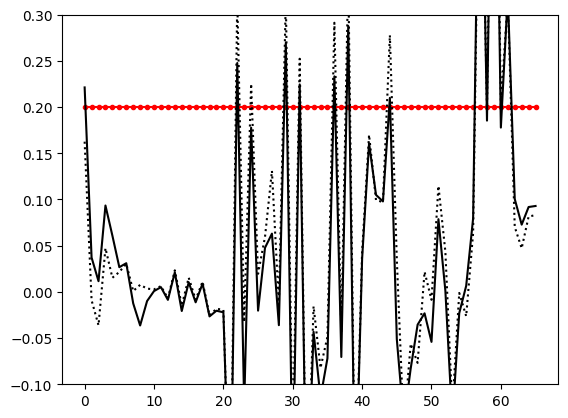

step: 61 0.17924296120427088
[[-4.3382492e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.5783762e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.1431692e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0930813e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.2755419e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0988504e-04]]
[ 0.22357158  0.03234173 -0.02257033  0.08402102  0.04130139  0.02443039
  0.03001941 -0.00253876  0.00293451  0.00367239  0.00256962  0.00663307
 -0.00289534  0.02236826 -0.00990781  0.01510806 -0.00714741  0.01095713
 -0.02298691 -0.0162559  -0.0171702  -0.25401542  0.25605488 -0.08386988
  0.23049057 -0.01426167  0.09467062  0.11068082 -0.0076263   0.32656464
 -0.24

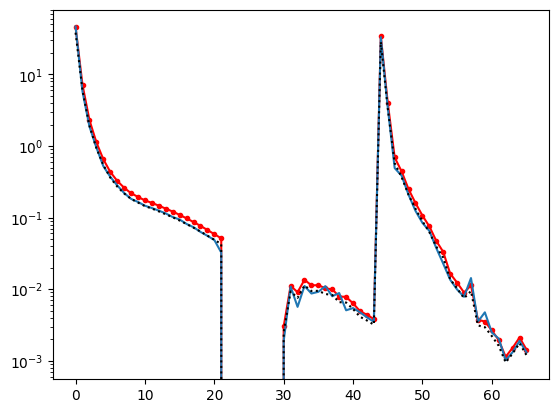

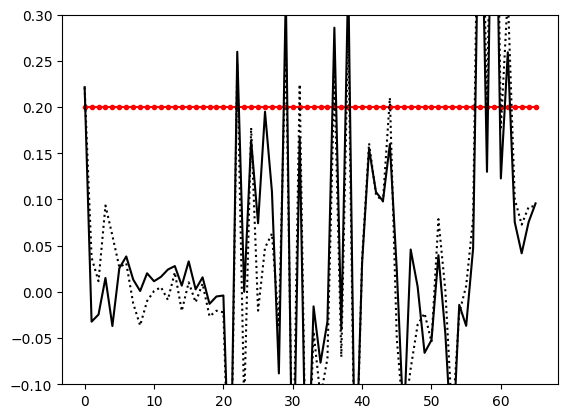

step: 64 0.17028081314405732
[[-1.1730461e-14  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.1276018e-16  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -8.6089788e-17 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.4951986e-11
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.3229944e-06  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -1.9582142e-08]]
[ 2.21571639e-01 -3.22356373e-02 -2.45330222e-02  1.50608532e-02
 -3.69365178e-02  2.56616250e-02  3.83518599e-02  1.33395921e-02
  9.20611143e-04  2.01243106e-02  1.15199937e-02  1.62641127e-02
  2.41508726e-02  2.79420558e-02  6.75230986e-03  3.30096446e-02
  2.74296501e-03  1.57592967e-02 -1.29522625e-02 -4.98005282e-03
 -4.01022285e-03 -2.40295842e-01  2.59838223e-

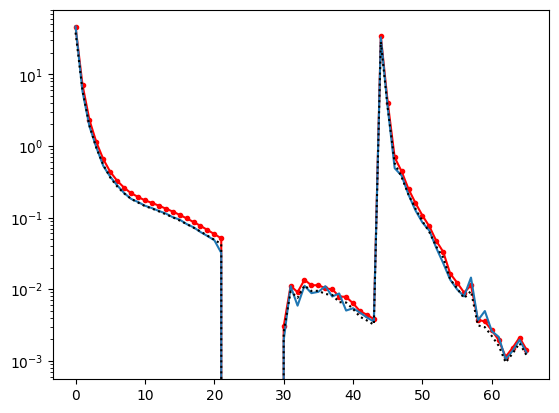

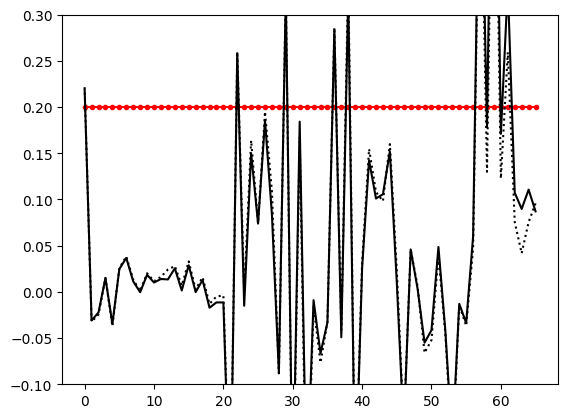

step: 67 0.16176677248685445
[[-6.78803623e-02  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -4.42902278e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.96829996e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.03329785e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -3.07330920e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.10184182e-04]]
[ 0.21966991 -0.01920073 -0.01321136  0.01661456 -0.02936709  0.02376649
  0.03497223  0.00900597 -0.00324149  0.01606762  0.00876455  0.01221166
  0.00747523  0.02401036 -0.00184005  0.02632225 -0.00169858  0.01164502
 -0.01867084 -0.01392138 -0.014511   -0.25253946  0.25727242 -0.05483912
  0.11009026  0.06719543  0.16235836  0.039

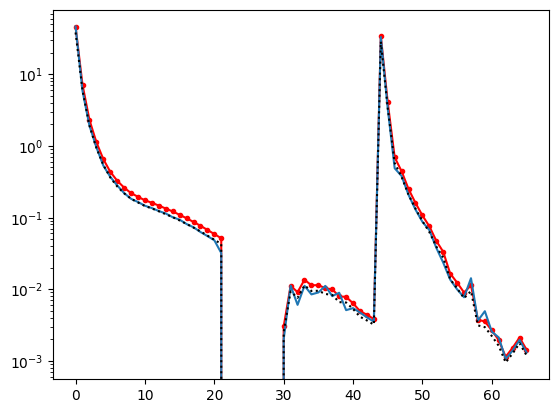

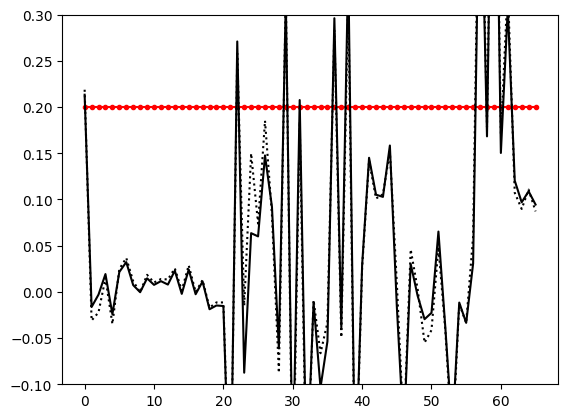

step: 70 0.15367843386251173
[[-1.0539998e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.5843259e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.8702206e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1268188e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0231595e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0797744e-04]]
[ 0.21402991 -0.02417783 -0.00146415  0.02040271 -0.0200666   0.02090284
  0.03158625  0.00656094 -0.00998703  0.01363403  0.00733321  0.01177974
  0.0113479   0.02307755 -0.00104867  0.02447117 -0.00189038  0.01160688
 -0.01812914 -0.01401287 -0.01448588 -0.25261524  0.2692881  -0.06609703
  0.07650644  0.06042494  0.13942672  0.09392467 -0.08082843  0.30263487
 -0.21

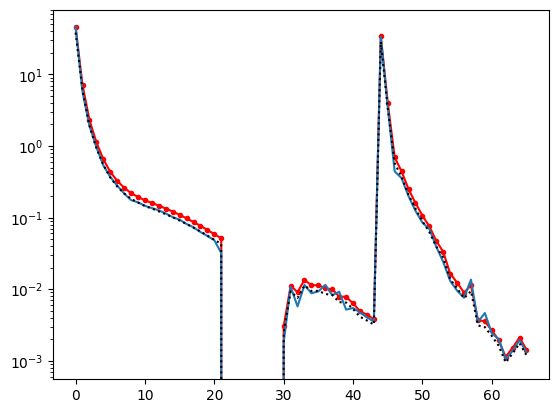

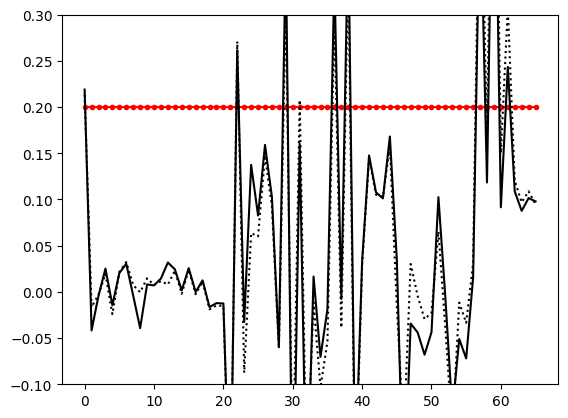

step: 73 0.14599451216938614
[[-1.14424795e-01  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00 -2.25385232e-03  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -2.62066227e-04 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.16433930e-05
   0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
  -3.02837088e-05  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
   0.00000000e+00 -2.10333048e-04]]
[ 0.2219439  -0.03933863 -0.00341456  0.02589053 -0.01275167  0.01957808
  0.02945049 -0.00374674 -0.03216677  0.00793505  0.00612737  0.01230253
  0.01736115  0.02230786 -0.00116708  0.02263295 -0.00229698  0.01103827
 -0.01869704 -0.0152843  -0.01561511 -0.25385156  0.25814602 -0.05598332
  0.147374    0.08141591  0.15249863  0.076

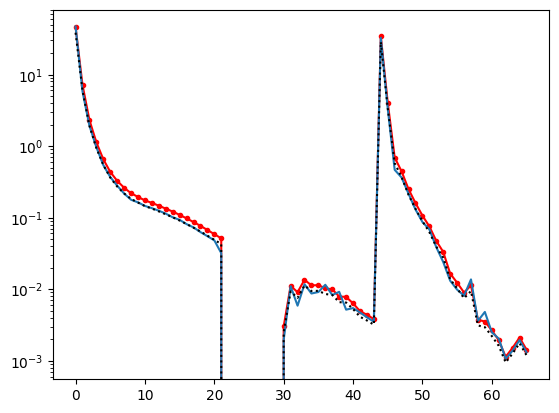

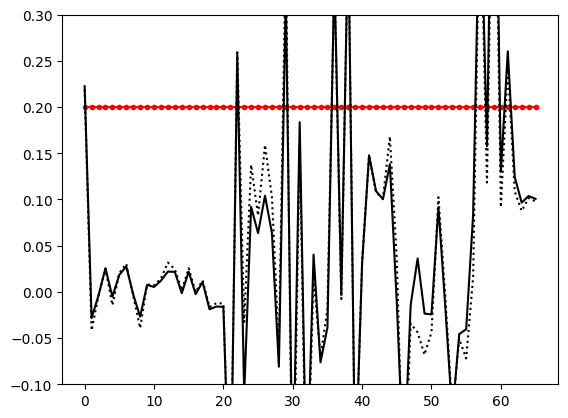

step: 76 0.13869478656091683
[[-1.9685017e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.0424431e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.5147744e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1397661e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0328145e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0926134e-04]]
[ 2.20560834e-01 -2.33074836e-02 -2.10594181e-02  2.38164123e-02
 -4.40340489e-03  1.62858833e-02  2.61768065e-02 -2.72916560e-03
 -2.78959218e-02  7.25409668e-03  5.40444814e-03  1.40255392e-02
  3.15210633e-02  2.30353009e-02  1.98187144e-03  2.39970852e-02
 -1.55348593e-04  1.20428940e-02 -1.65076330e-02 -1.32026235e-02
 -1.35266148e-02 -2.51663566e-01  2.66270459e-

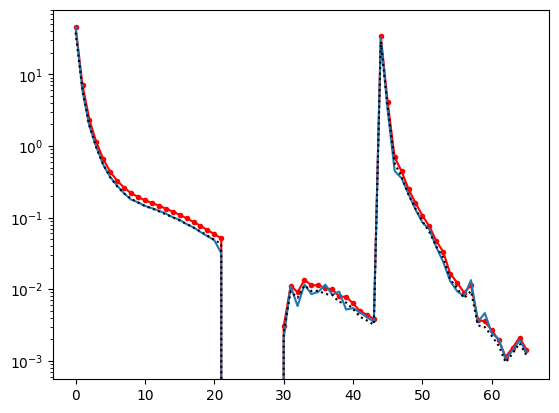

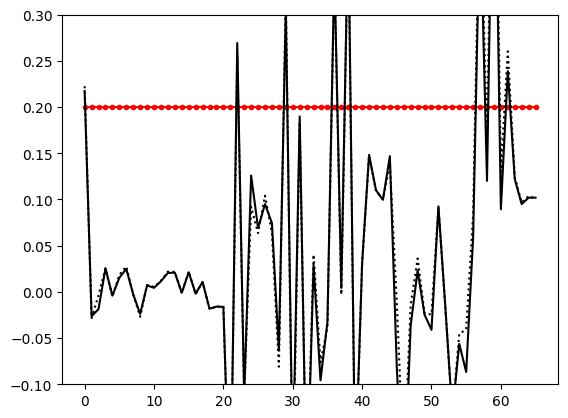

step: 79 0.131760047232871
[[-7.2597228e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.5457159e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.4788670e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1336810e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0464686e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0790966e-04]]
[ 2.18853235e-01 -2.70126816e-02 -1.71770658e-02  2.61186194e-02
 -3.20915342e-03  1.47586511e-02  2.42294855e-02 -2.35157064e-03
 -2.36147046e-02  6.64553884e-03  4.18432103e-03  1.16562666e-02
  2.15475932e-02  2.05878820e-02 -1.15934398e-03  2.07172018e-02
 -2.16059107e-03  1.06206061e-02 -1.82269327e-02 -1.60454400e-02
 -1.63716059e-02 -2.54935861e-01  2.68552989e-01

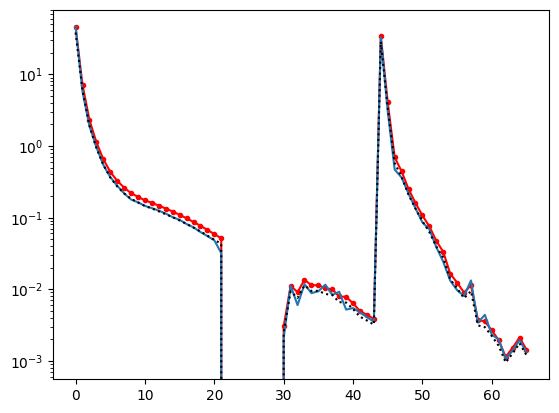

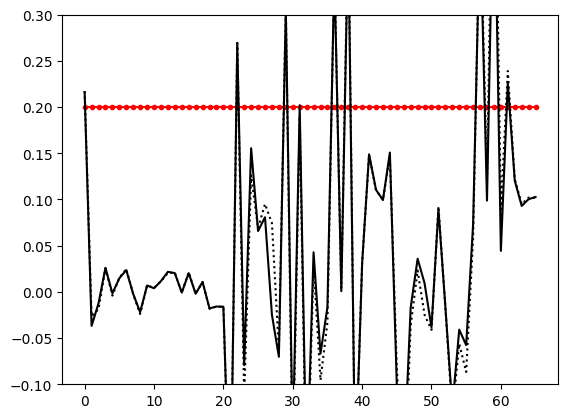

step: 82 0.12517204487122743
[[-7.8127190e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.1152663e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.2825025e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1487526e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0463743e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0977172e-04]]
[ 0.21518643 -0.04096577 -0.0093416   0.02643252 -0.00146879  0.01458559
  0.02316944 -0.00291731 -0.0256375   0.00595953  0.00353307  0.01074905
  0.01739548  0.01948701 -0.00163688  0.01935569 -0.00262645  0.0102081
 -0.01853254 -0.01678995 -0.01694558 -0.2554596   0.26952052 -0.05057426
  0.12976992  0.06014872  0.08049379 -0.01280559 -0.06481469  0.29795796
 -0.173

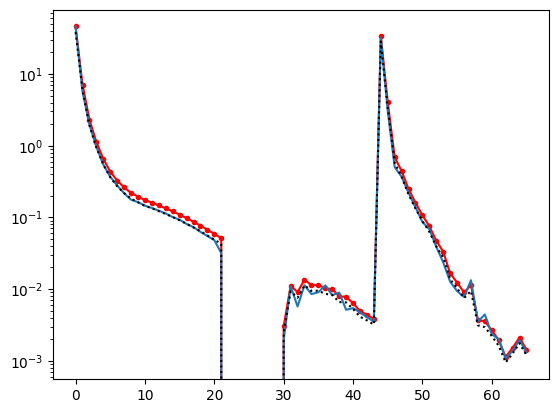

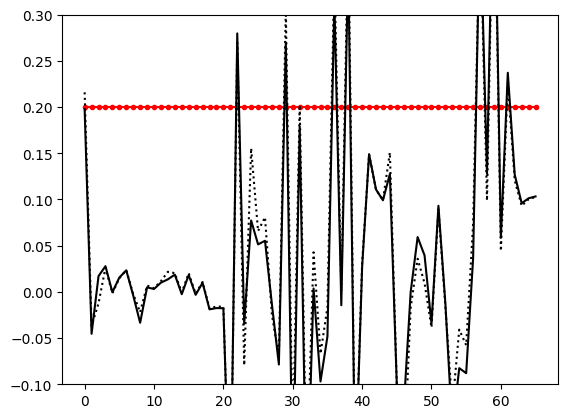

step: 85 0.11891344262766605
[[-6.3076682e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.0809885e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.4118730e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1405250e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0478262e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0801158e-04]]
[ 0.20301254 -0.01697811  0.03019965  0.01196169 -0.01767634  0.01169038
  0.02220942  0.00894344 -0.00465343  0.0136062   0.00445303  0.01375502
  0.03226747  0.0209287   0.00199903  0.02120717 -0.00047209  0.01146161
 -0.01631565 -0.01454092 -0.01463955 -0.2528352   0.27887157 -0.06317401
  0.10929769  0.08267215  0.0866541   0.01554656 -0.05119482  0.25926545
 -0.19

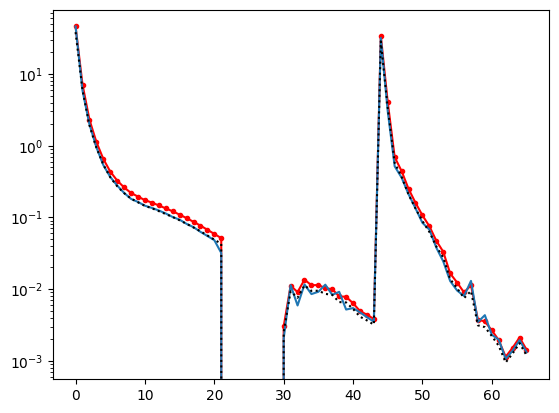

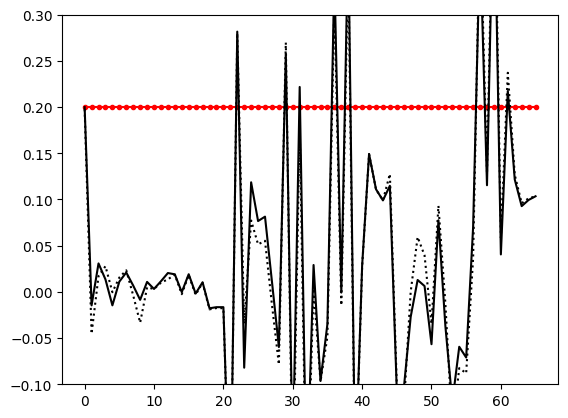

step: 88 0.11296777049628275
[[-2.8846461e-01  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.8998461e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -3.7299973e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1356150e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0471758e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0963293e-04]]
[ 1.86344147e-01 -3.02725704e-03  2.45636571e-02  1.15986839e-02
 -2.35536788e-02  1.06351627e-02  2.18492076e-02  1.16466060e-02
  3.95766459e-03  1.33375647e-02  3.65986698e-03  1.24988602e-02
  2.48361956e-02  1.92503091e-02  1.32988775e-04  1.90751310e-02
 -1.64673163e-03  1.05323512e-02 -1.74165275e-02 -1.62819196e-02
 -1.61964688e-02 -2.54518956e-01  2.86932528e-

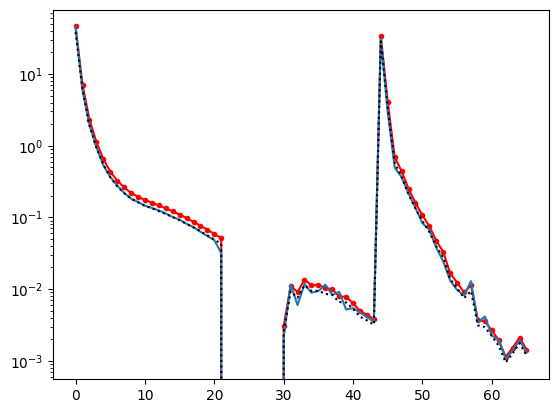

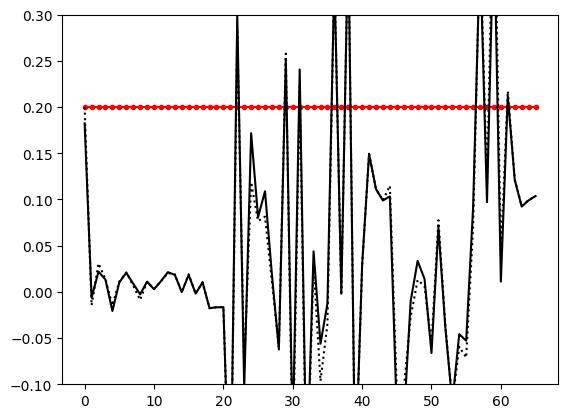

step: 91 0.1073193819714686
[[-4.1720744e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -5.8270334e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.2920122e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1465167e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0521074e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.1059906e-04]]
[ 0.18089569  0.00066328  0.02123964  0.01138126 -0.02713074  0.01027408
  0.02173856  0.01301509  0.00526363  0.01250704  0.00302291  0.0113902
  0.01894706  0.01803139 -0.00061553  0.01783879 -0.00214429  0.01006881
 -0.01787301 -0.0171625  -0.01699399 -0.25538686  0.30429903 -0.11395733
  0.1729041   0.08544854  0.13280332  0.04566814 -0.03721413  0.22976626
 -0.1382

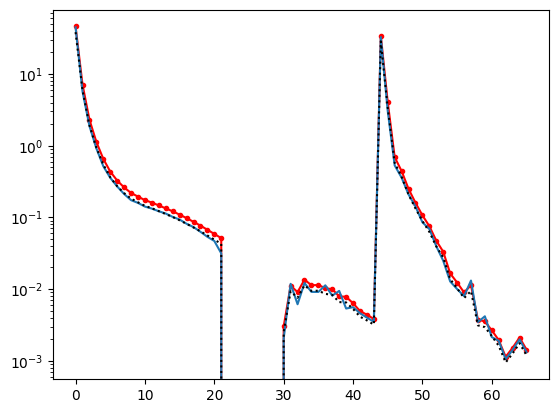

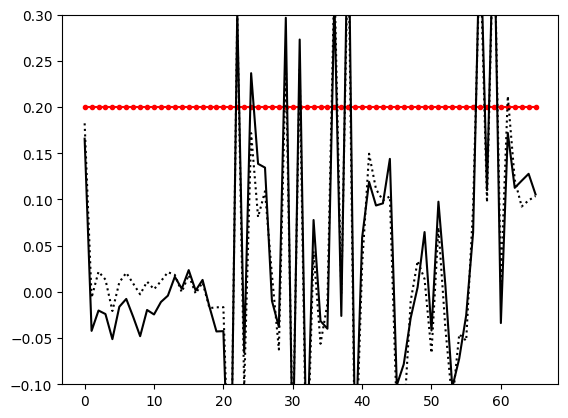

step: 94 0.10195341287289517
[[-1.5623599e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -3.3100569e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -2.3896541e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.0694938e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0012026e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0802679e-04]]
[ 0.16605179 -0.03933367 -0.01530001 -0.0214242  -0.04714644 -0.01527217
 -0.00724436 -0.02487892 -0.04052412 -0.01793188 -0.02356455 -0.00995117
 -0.00190528  0.01645578  0.00282332  0.02250737  0.00074926  0.01255325
 -0.01607583 -0.03966915 -0.03839263 -0.26160404  0.3023668  -0.08743131
  0.22089593  0.13192299  0.12537716 -0.02859974 -0.05383024  0.2999048
 -0.193

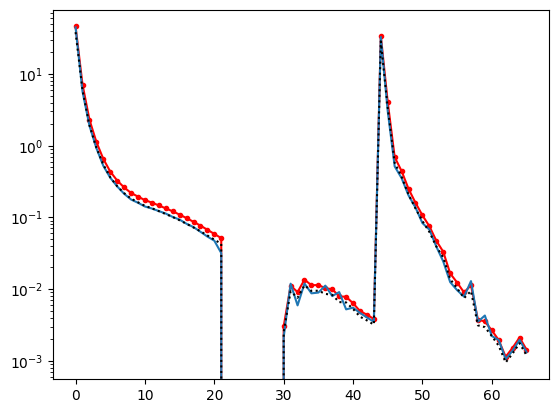

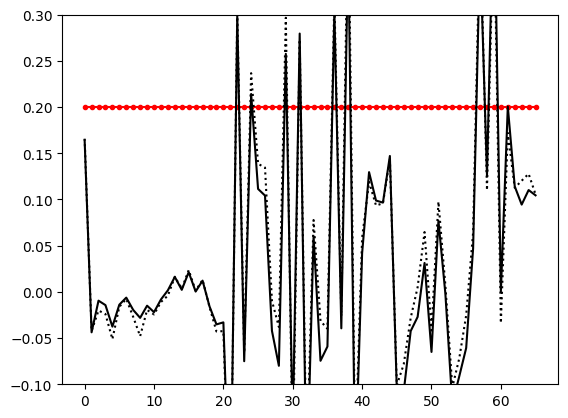

step: 97 0.0968557422292504
[[-6.0148947e-02  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -4.4378308e-03  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.7343323e-04 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.1298591e-05
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -2.9948427e-05  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -2.0948092e-04]]
[ 1.63518667e-01 -2.90543586e-02  1.06370600e-03 -7.78367231e-03
 -4.37439680e-02 -1.55087495e-02 -7.23515777e-03 -2.49350220e-02
 -4.01434116e-02 -1.65771432e-02 -2.21029632e-02 -8.32638144e-03
  5.86445167e-05  1.58391502e-02  2.01486098e-03  2.09653378e-02
  2.42732174e-04  1.20110353e-02 -1.58222634e-02 -3.43081616e-02
 -3.19362506e-02 -2.57551640e-01  2.87153989e-0

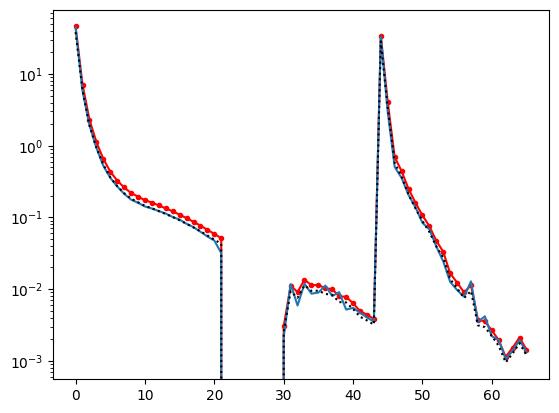

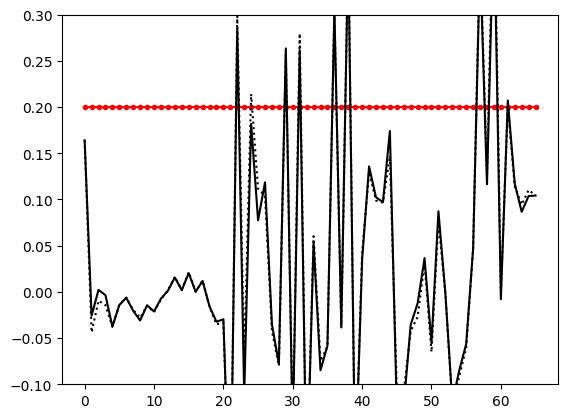

step: 100 0.09201295511778788
[[-2.9769187e-11  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00 -1.0174174e-12  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00 -1.6050693e-13 ...  0.0000000e+00
   0.0000000e+00  0.0000000e+00]
 ...
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -1.4581055e-08
   0.0000000e+00  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
  -3.0383725e-07  0.0000000e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
   0.0000000e+00 -3.5715525e-06]]
[ 1.64013579e-01 -2.57369336e-02  2.14806339e-03 -3.55954235e-03
 -3.76391672e-02 -1.41723286e-02 -6.36332808e-03 -2.05167700e-02
 -3.09027676e-02 -1.45173809e-02 -2.11759135e-02 -7.31148710e-03
  1.21403905e-03  1.55423880e-02  1.83489162e-03  2.02708673e-02
  1.27869469e-04  1.18538048e-02 -1.57080553e-02 -3.22757922e-02
 -2.95305140e-02 -2.57080346e-01  2.84912527e

In [22]:
from datetime import datetime, timedelta
from jax.scipy.optimize import minimize

from multiprocessing.pool import ThreadPool as Pool 
pool = Pool() #jax pmap? check re-compilation times?
pmap = pool.map

#method = 'L-BFGS-B'
method = "l-bfgs-experimental-do-not-rely-on-this"
θ_rtol = 1e-5
z_rtol = 1e-5

θ_tol = 1e-5
z_tol = 1e-6

history = []
α=0.5
beta = 0.25

θ̃ = start_point
θ = start_point# if result.θ is not None else θ_start)
θL = start_point
Nθ = len(ravel_θ(θ̃))
time = timedelta(0)
for i in range(1, maxsteps+1):
        print("step:",i,α)
        t0 = datetime.now()

        if i > 1:
            xs = [x_data] + [prob.sample_x_z(_rng, θ)[0] for _rng in _split_rng(rng,nsims)]
            θ_tol = np.sqrt(-np.diag(H̃_inv_post)) * θ_rtol

        if i > 2:
            Δθ̃ = ravel_θ(history[-1]["θ̃"])- ravel_θ(history[-2]["θ̃"])
          #  if np.sqrt(-np.inner(Δθ̃, np.inner(np.linalg.pinv(history[-1]["H̃_inv_post"]), Δθ̃))) < θ_rtol:
           #     break

        # MUSE gradient
        def get_MAPs(x_z):
            x, ẑ_prev = x_z
            result = prob.z_MAP_and_score(x, ẑ_prev, θ, method=method, z_tol=z_tol, θ_tol=θ_tol)
            
            return result

        MAPs = list(pmap(get_MAPs, zip(xs, ẑs)))

        ẑs = [MAP.z for MAP in MAPs]
   #     if save_MAP_history:
    #        MAP_history_dat, *MAP_history_sims = [MAP.history for MAP in MAPs]
        s_MAP_dat, *s_MAP_sims = [MAP.s for MAP in MAPs]
        s̃_MAP_dat, *s̃_MAP_sims = [MAP.s̃ for MAP in MAPs]
        s̃_MUSE = unravel_θ(ravel_θ(s̃_MAP_dat) - np.nanmean(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        s̃_prior, H̃_prior = gradθ_hessθ_logPrior(θ̃, transformed_θ=True)
        s̃_post = unravel_θ(ravel_θ(s̃_MUSE) + ravel_θ(s̃_prior))

        # print(s̃_MAP_sims)
        # H̃_inv_like_sims = np.diag(-1 / np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0))
        epsilon = 1e-8  # A small value to avoid division by zero
        variance = np.nanvar(np.stack(list(map(ravel_θ, s̃_MAP_sims))), axis=0)
        variance += epsilon  # Add epsilon to the variance to prevent zero values
        H̃_inv_like_sims = np.diag(-1 / variance)
        print(H̃_inv_like_sims)
        
       # try:
        # H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        H̃_inv_post = np.linalg.pinv(np.linalg.pinv(H̃_inv_like_sims) + ravel_θ(H̃_prior).reshape(Nθ,Nθ))
        #except:
        #    print("error on Hessian inversion calc, prior ignored and trying again...")
       # H̃_inv_post = H̃_inv_like_sims
        t = datetime.now() - t0
        time += t

        history.append({
            "t":t, "θ̃":θ̃, "θ":θ,
            "s_MAP_dat": s_MAP_dat, "s_MAP_sims": s_MAP_sims,
            "s̃_MAP_dat": s̃_MAP_dat, "s̃_MAP_sims": s̃_MAP_sims, 
            "s̃_MUSE": s̃_MUSE,
            "s̃_prior": s̃_prior, "s̃_post": s̃_post, 
            "H̃_inv_post": H̃_inv_post, "H̃_prior": H̃_prior, 
            "H̃_inv_like_sims": H̃_inv_like_sims,
            "θ_tol": θ_tol,
        #    "MAP_history_dat": MAP_history_dat, 
         #   "MAP_history_sims": MAP_history_sims,
        })
        θ̃update = np.clip((np.inner(H̃_inv_post, ravel_θ(s̃_post))),-jnp.abs(ravel_θ(θ̃)*beta),jnp.abs(ravel_θ(θ̃)*beta))
        θ̃ = unravel_θ((ravel_θ(θ̃) - α * θ̃update))
        θ = θ̃
        print(((θ-tf_cut_flat)/tf_cut_flat))
        #print(θ)
        if i%3==0:
            plt.semilogy(start_point,"r.-")
            plt.plot(θ)
            plt.plot(tf_cut_flat,"k:")
            plt.show()
            
            
            plt.plot((start_point-tf_cut_flat)/tf_cut_flat,"r.-")
            plt.plot((θ-tf_cut_flat)/tf_cut_flat,"k")
            plt.plot((θL-tf_cut_flat)/tf_cut_flat,"k:")
    
            plt.ylim([-.1,.3])
            plt.show()
            
            θL = θ
            #LR decay
            α *= 0.95

In [23]:
#as you can see, convergence properties are wonky, takes a bit of time to start moving... 
#Should converge if you have the patients to let it run a couple of hours


In [24]:
#Now lets try to calculate the covariance! :D

In [25]:
s_MAP_sims = history[-1]["s_MAP_sims"]
_, *z_MAP_sims = ẑs

In [26]:
def z_MAP_guess_from_truth(x, z, θ):
        return unravel_z(0 * ravel_z(z))
    
nsims = 4
    
def get_J(
        result = None,
        θ = None,
        θ_tol = None,
        z_tol = None,
        method = None,
        rng = None,
        nsims = 10, 
        pmap = map,
        progress = False, 
        skip_errors = False,
    ):

        nsims_remaining = nsims 

        if nsims_remaining > 0:
            print(nsims_remaining)
            t0 = datetime.now()

            def get_s_MAP(rng):
                    (x, z) = prob.sample_x_z(rng, θ)
                    # if np.isnan(x).any() or np.isnan(z).any():
                    #     print("NaN detected in sampled (x, z)")
                    #     return None                    
                    z_MAP_guess = prob.z_MAP_guess_from_truth(x, z, θ)
                    # if np.isnan(z_MAP_guess).any():
                    #     print("NaN detected in z_MAP_guess!")
                    #     return None

                    #     result = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol)
                    #     if np.isnan(result.s).any():
                    #         print("NaN detected in s_MAP!")
                    #         return None
                    return prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).s
                

            rngs = _split_rng(rng, nsims_remaining)
            s_MAP_sims.extend(s for s in pmap(get_s_MAP, rngs) if s is not None)

#            time += datetime.now() - t0

        stacked_s = np.stack(list(map(ravel_θ, s_MAP_sims)))
        print("Stacked s_MAP_sims shape:", stacked_s.shape)
        print("Stacked s_MAP_sims values:", stacked_s)
        
        if np.isnan(stacked_s).any():
            print("NaN detected in stacked_s before computing J!")
            exit()
        J = np.atleast_2d(np.cov(np.stack(list(map(ravel_θ, s_MAP_sims))), rowvar=False))
        return J



In [27]:
J = get_J(rng=rng,θ =θ,method=method, θ_tol=θ_tol, z_tol=z_tol)

10
Stacked s_MAP_sims shape: (20, 66)
Stacked s_MAP_sims values: [[ 4.63166809e+01  8.32916992e+02  5.51206543e+03 ... -3.98623438e+04
  -1.39209043e+04 -2.39577344e+03]
 [ 4.40226364e+01  8.21914612e+02  5.55767725e+03 ... -3.93570312e+04
  -1.38434590e+04 -2.29331152e+03]
 [ 4.82822227e+01  8.10680786e+02  5.47256934e+03 ... -4.01160430e+04
  -1.39772363e+04 -2.42878394e+03]
 ...
 [-1.56001045e+04 -7.88871953e+04 -5.75238125e+05 ... -6.35836250e+04
  -2.03048867e+04 -3.22380444e+03]
 [-9.59749832e+01  2.28139160e+02  5.98183545e+03 ... -3.55530391e+04
  -1.21049238e+04 -1.95538123e+03]
 [-7.07764160e+03  7.36669531e+03  1.69783984e+03 ... -2.70393867e+04
  -7.61047363e+03 -1.01330573e+03]]


In [28]:
J

array([[ 1.85221625e+10,  1.00205654e+11,  2.52244274e+11, ...,
        -8.04255372e+08, -1.56188917e+08,  5.96760449e+07],
       [ 1.00205654e+11,  5.42254667e+11,  1.36451737e+12, ...,
        -4.31405008e+09, -8.32066963e+08,  3.25295805e+08],
       [ 2.52244274e+11,  1.36451737e+12,  3.44905922e+12, ...,
        -1.08485995e+10, -2.07393680e+09,  8.25313226e+08],
       ...,
       [-8.04255372e+08, -4.31405008e+09, -1.08485995e+10, ...,
         1.17903750e+08,  3.28396954e+07,  1.33660314e+06],
       [-1.56188917e+08, -8.32066963e+08, -2.07393680e+09, ...,
         3.28396954e+07,  1.02157609e+07,  9.42287409e+05],
       [ 5.96760449e+07,  3.25295805e+08,  8.25313226e+08, ...,
         1.33660314e+06,  9.42287409e+05,  4.47610474e+05]])

In [29]:
Hs = []

In [30]:
def pjacobian(f, x, step, pmap=map, pbar=None):
    print(step,x)
    step = step + np.array(0 * x) # make array if scalar

    def column(i):
    
        def v(ε):
            ε_vec = np.array(0 * x)
            ε_vec[i] = ε
            v = f(x + ε_vec)
            if pbar: pbar.update()
            return v

        return (v(step[i]) - v(-step[i])) / (2 * step[i])

    return np.array(list(pmap(column, range(len(x)))))

In [31]:
#This takes a while, roughly an hour or two... Can probably parallelize it across GPUs if you want.

from tqdm import tqdm
from jax.scipy.sparse.linalg import cg

step = None
skip_errors = False
def _get_H_i_old(rng, z_MAP_guess_fid, *, θ, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):
    
    # for each sim, do one fit at fiducial which we'll
    # reuse as a starting point when fudging θ by +/-ϵ
    θfid = θ
    (x, z) = prob.sample_x_z(rng, θfid)
    if z_MAP_guess_fid is None:
        z_MAP_guess = _MAP_guess_from_truth(x, z, θfid)
        z_MAP_guess_fid = z_MAP_and_score(x, z_MAP_guess, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).z

    def get_s_MAP(θvec):
        θ = unravel_θ(θvec)
        (x, _) = prob.sample_x_z(copy(rng), θ)
        return ravel_θ(prob.z_MAP_and_score(x, z_MAP_guess_fid, θfid, method=method, θ_tol=θ_tol, z_tol=z_tol).s)

    return pjacobian(get_s_MAP, ravel_θ(θfid), step)


def _get_H_i(rng, z_MAP, *, θ, implicit_diff_cgtol=1e-3, method=None, θ_tol=None, z_tol=None, step=None, skip_errors=False):

        #implicit implementation..
        cg_kwargs = dict(tol=implicit_diff_cgtol)

        (x, z) = prob.sample_x_z(rng, θ)
        if z_MAP is None:
            z_MAP_guess = z_MAP_guess_from_truth(x, z, θ)
            z_MAP = prob.z_MAP_and_score(x, z_MAP_guess, θ, method=method, θ_tol=θ_tol, z_tol=z_tol).z

        θ_vec, z_MAP_vec = ravel_θ(θ), ravel_z(z_MAP)
        #unravel_θ, unravel_z = unravel_θ, unravel_z

        # non-implicit-diff term
        H1 = jacfwd(
            lambda θ1: grad(
                lambda θ2: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], z_MAP, unravel_θ(θ2))
            )(θ_vec)
        )(θ_vec)

        # term involving dzMAP/dθ via implicit-diff (w/ conjugate-gradient linear solve)
        dFdθ = jacfwd(
            lambda θ: grad(
                lambda z: prob.logLike(x, unravel_z(z), unravel_θ(θ))
            )(z_MAP_vec)
        )(θ_vec)
        dFdθ1 = jacfwd(
            lambda θ1: grad(
                lambda z: prob.logLike(prob.sample_x_z(rng, unravel_θ(θ1))[0], unravel_z(z), θ)
            )(z_MAP_vec)
        )(θ_vec)
        inv_dFdz_dFdθ1 = vmap(
            lambda vec: cg(
                lambda vec: jvp(lambda z: grad(lambda z: prob.logLike(x, unravel_z(z), θ))(z), (z_MAP_vec,), (vec,))[1], 
                vec, 
                **cg_kwargs
            )[0], 
            in_axes=1, out_axes=1
        )(dFdθ1)
        H2 = -dFdθ.T @ inv_dFdz_dFdθ1
        return H1 + H2

Hs = []

nsims_remaining = nsims  #- len(result.Hs)

z_MAP_sims = z_MAP_sims[:4]

if nsims_remaining > 0:

    # default to finite difference step size of 0.1σ with σ roughly
    # estimated from s_MAP_sims sims, if we have them
    if step is None:
        if len(s_MAP_sims) > 0:
            step = 0.1 / np.std(np.stack(list(map(ravel_θ, s_MAP_sims))), axis=0)
        else:
            step = 1e-5
    
    Nθ = len(ravel_θ(θ))
    pbar = partial(tqdm, total=nsims_remaining, desc="get_H", disable=(True))

    t0 = datetime.now()
    rngs = _split_rng(rng, nsims)[-nsims_remaining:]
    z_MAP_sims = (z_MAP_sims + [None]*(max(0, nsims - len(z_MAP_sims))))[-nsims_remaining:]
    _get_H_ii = partial(_get_H_i, θ=θ, method=method, θ_tol=θ_tol, z_tol=z_tol, step=step, skip_errors=skip_errors)
    Hs.extend(H for H in pbar(map(lambda args: _get_H_ii(*args), zip(rngs, z_MAP_sims)) )if H is not None)
   # result.time += datetime.now() - t0

avg = np.mean#np.median if use_median else np.mean
H = avg(np.array(Hs), axis=0)

In [32]:
Hs[0]

Array([[ 1.67773438e+00,  2.94433594e+00, -1.14947510e+00, ...,
         2.12465286e-01, -5.08937836e-02, -2.31046677e-02],
       [ 2.91113281e+00,  1.14468750e+02,  1.13671875e+02, ...,
         7.36366272e-01, -1.84436798e-01, -3.76081467e-02],
       [ 1.69433594e-01,  1.16171875e+02,  2.05125000e+03, ...,
         1.03485107e-01,  4.25094604e-01,  5.55839539e-02],
       ...,
       [-3.34072113e-03, -1.79325104e-01,  1.55578613e-01, ...,
         6.70659062e+04,  1.26682656e+04,  6.03051025e+02],
       [-5.13753891e-02, -1.02577209e-01, -1.30502701e-01, ...,
         1.30102227e+04,  2.11113203e+04,  2.74169238e+03],
       [-1.03683472e-02, -1.24940872e-02, -1.95369720e-02, ...,
         7.37442871e+02,  2.73642383e+03,  3.19577930e+03]],      dtype=float32)

In [33]:
import scipy as sp

Nθ = len(ravel(θ))

H_prior = -ravel(prob.gradθ_hessθ_logPrior(θ, transformed_θ=False)[1]).reshape(Nθ,Nθ)
Σ_inv = H.T @ np.linalg.pinv(J) @ H + H_prior
Σ = np.linalg.pinv(Σ_inv)

try:
    if θ is not None:
        if Nθ == 1:
            dist = sp.stats.norm(ravel(θ), np.sqrt(Σ[0,0]))
        else:
            dist = sp.stats.multivariate_normal(ravel(θ), Σ)
except:
    print("likely error in covariance... proceed with caution!")

likely error in covariance... proceed with caution!


In [43]:
cond_number = np.linalg.cond(J)
print(f"Condition number of J: {cond_number}")
if cond_number > 1e12:
    print("Warning: J is nearly singular!")

Condition number of J: 3.93207292672006e+25


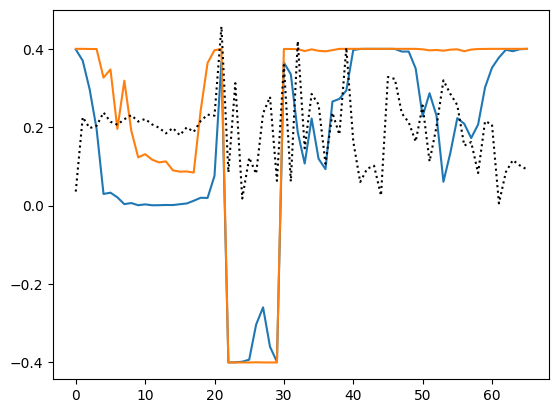

In [34]:
plt.plot(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat)
plt.plot(np.sqrt(np.diag(Σ))/tf_cut_flat)

plt.plot(abs((start_point-θ)/tf_cut_flat),"k:")

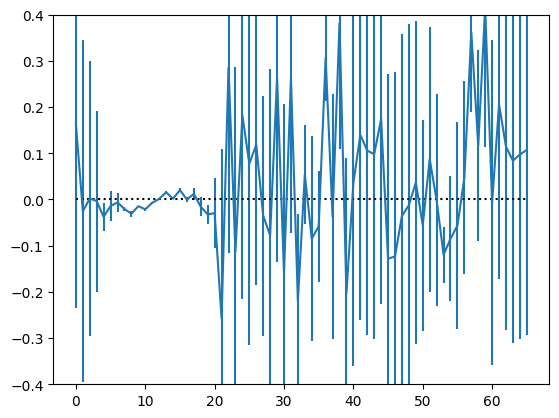

In [35]:
#need to run optimization for longer, since thsoe smaller scale modes in each mu-bin are not converged...
plt.errorbar(np.arange(len(tf_cut_flat)),(θ-tf_cut_flat)/tf_cut_flat,yerr=np.abs(1/np.sqrt(np.diag(Σ_inv))/tf_cut_flat))
plt.plot(np.arange(len(tf_cut_flat)),np.arange(len(tf_cut_flat))*0.0,"k:")
plt.ylim(-0.4,0.4)
plt.show()

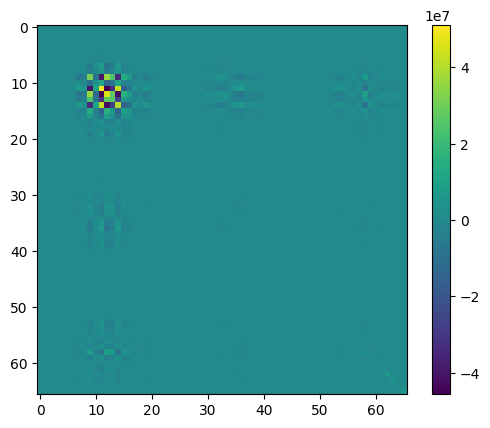

In [36]:
imshow(Σ_inv)
colorbar()